In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import legend

price = pd.read_excel('ETF without bond.xlsx',index_col=0)
market_cap = pd.read_excel('ETF without bond.xlsx', index_col=0, sheet_name='market cap')

<Axes: xlabel='Code'>

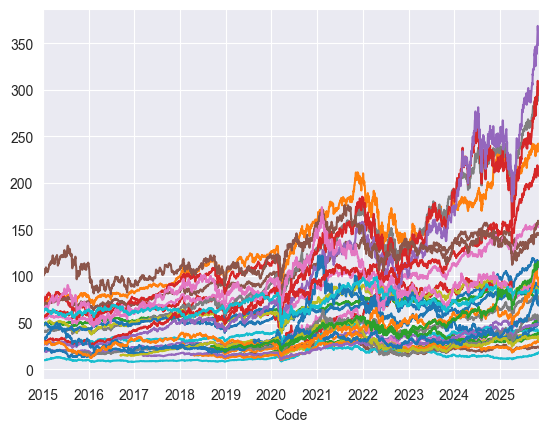

In [47]:
price.plot(legend = False)

In [48]:
weekly_ret = price.pct_change(fill_method=None).loc['2015':]

In [49]:
market_weight = market_cap.div(market_cap.sum(axis = 1), axis=0)

In [50]:
import numpy as np
import pandas as pd
from scipy.cluster.hierarchy import linkage, leaves_list
from scipy.spatial.distance import squareform
from scipy.optimize import minimize

# =============== Utils ===============
def month_end_business_days(index: pd.DatetimeIndex) -> pd.DatetimeIndex:
    grp = pd.Series(1, index=index).groupby(index.to_period('M'))
    last_idx = grp.apply(lambda s: s.index.max())
    return pd.DatetimeIndex(last_idx.values)

def nearest_on_or_before(idx: pd.DatetimeIndex, t: pd.Timestamp) -> pd.Timestamp | None:
    """idx에서 t 이전(포함) 가장 가까운 날짜 반환; 없으면 None."""
    pos = idx.searchsorted(t, side="right") - 1
    if pos < 0:
        return None
    return idx[pos]

def nearest_psd(cov: pd.DataFrame, eps: float = 1e-8) -> pd.DataFrame:
    cov = (cov + cov.T) * 0.5
    vals, vecs = np.linalg.eigh(cov.values)
    vals = np.clip(vals, eps, None)
    out = vecs @ np.diag(vals) @ vecs.T
    return pd.DataFrame(out, index=cov.index, columns=cov.columns)

def cov_to_corr(cov: pd.DataFrame, eps: float = 1e-12) -> pd.DataFrame:
    std = np.sqrt(np.diag(cov.values)).clip(min=eps)
    inv_std = np.diag(1.0 / std)
    corr = inv_std @ cov.values @ inv_std
    return pd.DataFrame(corr, index=cov.index, columns=cov.columns)

def corr_to_cov(corr: pd.DataFrame, vol: pd.Series) -> pd.DataFrame:
    D = np.diag(vol.values)
    cov = D @ corr.values @ D
    return pd.DataFrame(cov, index=corr.index, columns=corr.columns)

def corr_distance(corr: pd.DataFrame) -> pd.DataFrame:
    return pd.DataFrame(np.sqrt(0.5*(1.0 - corr.clip(-1,1))),
                        index=corr.index, columns=corr.columns)

# =============== Denoise/Detone ===============
def mp_denoise_constant_corr(corr: pd.DataFrame, T: int) -> pd.DataFrame:
    """Marčenko–Pastur constant-eigenvalue clipping on correlation."""
    n = corr.shape[0]
    if n <= 1:
        return corr.copy()
    q = max(T / float(n), 1.0000001)  # 안정성
    lambda_plus = (1.0 + 1.0/np.sqrt(q))**2

    vals, vecs = np.linalg.eigh(corr.values)
    mask = vals <= lambda_plus
    if mask.sum() > 0:
        vals[mask] = vals[mask].mean()
    C = vecs @ np.diag(vals) @ vecs.T
    C = (C + C.T) * 0.5
    C = pd.DataFrame(C, index=corr.index, columns=corr.columns)
    np.fill_diagonal(C.values, 1.0)
    return C

def detone_market_mode(corr: pd.DataFrame) -> pd.DataFrame:
    """Remove top eigenmode (market), then restore unit diagonal."""
    vals, vecs = np.linalg.eigh(corr.values)
    i_max = np.argmax(vals)
    v1 = vecs[:, [i_max]]
    l1 = vals[i_max]
    C = corr.values - l1 * (v1 @ v1.T)
    C = (C + C.T) * 0.5
    C = pd.DataFrame(C, index=corr.index, columns=corr.columns)
    np.fill_diagonal(C.values, 1.0)
    return C

# =============== Within-cluster solvers & NCO ===============
def ivp_weights_from_cov(cov: pd.DataFrame, eps: float = 1e-12) -> pd.Series:
    var = pd.Series(np.diag(cov.values), index=cov.index).clip(lower=eps)
    inv = 1.0 / var
    w = inv / inv.sum()
    return w

def minvar_longonly_from_cov(cov: pd.DataFrame) -> pd.Series:
    cov = nearest_psd(cov)
    n = len(cov)
    if n == 1:
        return pd.Series([1.0], index=cov.index)
    C = cov.values
    def obj(w): return w @ C @ w
    cons = [{'type':'eq','fun':lambda w: np.sum(w) - 1.0}]
    bnds = [(0.0, 1.0)] * n
    x0 = np.ones(n)/n
    res = minimize(obj, x0, method='SLSQP', bounds=bnds, constraints=cons)
    if not res.success:
        raise ValueError(f"MinVar failed: {res.message}")
    return pd.Series(res.x, index=cov.index)

def cluster_portfolio_variance(cov: pd.DataFrame, names: list[str], within: str='ivp') -> float:
    sub = cov.loc[names, names]
    w = ivp_weights_from_cov(sub) if within=='ivp' else minvar_longonly_from_cov(sub)
    return float(w.values @ sub.values @ w.values)

def nco_weights(cov: pd.DataFrame, linkage_method: str='ward', within: str='ivp') -> pd.Series:
    if cov.shape[0] == 1:
        return pd.Series([1.0], index=cov.index)
    corr = cov_to_corr(cov)
    dist = corr_distance(corr)
    Z = linkage(squareform(dist.values, checks=False), method=linkage_method)
    order = leaves_list(Z)
    ordered = list(cov.index[order])

    w = pd.Series(1.0, index=ordered)
    clusters = [ordered]
    while clusters:
        nxt = []
        for cl in clusters:
            if len(cl) <= 1:
                continue
            k = len(cl)//2
            L, R = cl[:k], cl[k:]
            vL = cluster_portfolio_variance(cov, L, within)
            vR = cluster_portfolio_variance(cov, R, within)
            aL = 1.0 - vL/(vL+vR)
            aR = 1.0 - aL
            w[L] *= aL
            w[R] *= aR
            nxt += [L, R]
        clusters = nxt
    w = w.clip(lower=0)
    w /= w.sum()
    return w.reindex(cov.index)

# =============== BL (views from target weights) ===============
def build_views_from_target_weights(
    Sigma: pd.DataFrame,
    w_target: pd.Series,
    delta: float = 3.0,
    tau: float = 0.02,
    confidence: float = 0.5
):
    """
    후험 예측용 뷰 생성:
      - μ_view = δ Σ w_target (역최적화)
      - P = I, Q = μ_view
      - Ω = ((1-c)/c) * τ * diag(Σ)
    """
    w = w_target.reindex(Sigma.index).fillna(0.0)
    if w.sum() <= 0:
        raise ValueError("w_target has zero mass on current universe.")
    w = w / w.sum()

    mu_view = delta * (Sigma.values @ w.values.reshape(-1,1))  # n x 1
    Q = pd.Series(mu_view.ravel(), index=Sigma.index)
    P = pd.DataFrame(np.eye(len(Sigma)), index=Sigma.index, columns=Sigma.index)
    scale = (1.0 - confidence) / confidence  # c=0.5 -> 1
    Omega_diag = scale * tau * np.diag(Sigma.values)          # vector length n
    Omega = pd.DataFrame(np.diag(Omega_diag), index=Sigma.index, columns=Sigma.index)
    return {"P": P, "Q": Q, "Omega": Omega, "tau": tau, "delta": delta}

def bl_posterior_mean(
    Sigma: pd.DataFrame,
    P: pd.DataFrame,
    Q: pd.Series,
    Omega: pd.DataFrame,
    tau: float,
    pi: pd.Series = None  # 사전 평형수익률(없으면 0 벡터로 가정)
) -> pd.Series:
    """
    μ_post = M [ (τΣ)^-1 π + Pᵀ Ω^-1 Q ],  M = ((τΣ)^-1 + Pᵀ Ω^-1 P)^-1
    """
    Σ = nearest_psd(Sigma)
    n = Σ.shape[0]
    π = (pi.reindex(Σ.index) if pi is not None else pd.Series(0.0, index=Σ.index)).values.reshape(-1,1)

    Σ_tau_inv = np.linalg.pinv(tau * Σ.values)
    Ω_inv = np.linalg.pinv(Omega.values)
    Pm = P.reindex(columns=Σ.index).values
    Qv = Q.reindex(index=Σ.index).values.reshape(-1,1)

    M_inv = Σ_tau_inv + Pm.T @ Ω_inv @ Pm
    M = np.linalg.pinv(M_inv)
    mu_post = M @ (Σ_tau_inv @ π + Pm.T @ Ω_inv @ Qv)
    return pd.Series(mu_post.ravel(), index=Σ.index)

def bl_posterior_cov(Sigma: pd.DataFrame, P: pd.DataFrame, Q: pd.Series, Omega: pd.DataFrame, tau: float) -> pd.DataFrame:
    """
    후험 예측 공분산: Σ_post = Σ + M,  M = ((τΣ)^-1 + PᵀΩ^-1P)^-1
    (PSD 보장/안정형)
    """
    Σ = nearest_psd(Sigma)
    Σ_tau_inv = np.linalg.pinv(tau * Σ.values)
    Ω_inv = np.linalg.pinv(Omega.values)
    A = P.values.T @ Ω_inv @ P.values
    M_inv = Σ_tau_inv + A
    M = np.linalg.pinv(M_inv)
    Σ_post = Σ.values + M
    return nearest_psd(pd.DataFrame(Σ_post, index=Σ.index, columns=Σ.columns))

def blend_with_view(w_nco: pd.Series, w_target: pd.Series, alpha: float) -> pd.Series:
    """
    최종 가중치 = (1-alpha) * w_nco + alpha * w_target
    alpha ∈ [0,1]. 보통 confidence를 그대로 사용.
    """
    w_t = w_target.reindex(w_nco.index).fillna(0.0)
    s = w_t.sum()
    if s <= 0:  # 뷰가 비어있으면 그대로 반환
        return (w_nco.clip(lower=0) / w_nco.clip(lower=0).sum())
    w_t = w_t / s
    w = (1 - alpha) * w_nco + alpha * w_t
    w = w.clip(lower=0)
    return w / w.sum()

# =============== Rolling posterior-NCO (predictive BL + denoise/detone) ===============
def rolling_posterior_nco(
    returns: pd.DataFrame,         # 일간 수익률 (index=영업일, columns=자산)
    market_weight: pd.DataFrame,   # 일간(or 영업일) 타깃 비중 (각 행 합≈1)
    lookback_days: int = 252,
    linkage_method: str = 'ward',
    within: str = 'ivp',
    # BL hyper
    delta: float = 3.0,
    tau: float = 0.02,
    confidence: float = 0.5,
    # denoise/detone
    denoise: bool = True,
    detone: bool = True,
    fillna_zero: bool = False
) -> pd.DataFrame:

    dates = returns.index
    mes = month_end_business_days(dates)
    mw_idx = market_weight.index

    weights_at_me = {}

    for i in range(1, len(mes)):  # 직전 월말 필요
        t = mes[i]
        t_prev = mes[i-1]

        # market_weight에서 't_prev와 같거나 직전'에 해당하는 가장 가까운 날짜를 사용
        mw_t_prev = nearest_on_or_before(mw_idx, t_prev)
        if mw_t_prev is None:
            continue

        pos = dates.get_loc(t)
        if isinstance(pos, slice):
            pos = pos.stop - 1
        start = pos - lookback_days
        if start < 0:
            continue

        window = returns.iloc[start:pos]  # t 전일까지(look-ahead 방지)
        valid = window.dropna(axis=1, how='any')
        if valid.shape[1] == 0:
            continue

        # 표본 Σ
        Sigma_raw = nearest_psd(valid.cov())

        # 디노이즈/디톤 (상관 기준)
        if denoise or detone:
            vols = pd.Series(np.sqrt(np.diag(Sigma_raw.values)), index=Sigma_raw.index)
            Corr = cov_to_corr(Sigma_raw)
            if denoise:
                Corr = mp_denoise_constant_corr(Corr, T=len(window))
            if detone:
                Corr = detone_market_mode(Corr)
            Sigma = nearest_psd(corr_to_cov(Corr, vols))
        else:
            Sigma = Sigma_raw

        # 뷰: '직전 월말(또는 그 이전 최근 영업일)'의 market_weight 사용
        w_target = market_weight.loc[mw_t_prev].reindex(Sigma.index).fillna(0.0)
        if w_target.sum() <= 0:
            continue
        w_target = w_target / w_target.sum()

        # BL posterior (predictive): Σ_post = Σ + M
        views = build_views_from_target_weights(Sigma, w_target, delta=delta, tau=tau, confidence=confidence)
        P = views["P"].reindex(index=Sigma.index, columns=Sigma.index)
        Q = views["Q"].reindex(index=Sigma.index)
        Omega = views["Omega"].reindex(index=Sigma.index, columns=Sigma.index)
        Sigma_post = bl_posterior_cov(Sigma, P, Q, Omega, tau=views["tau"])

        # NCO (long-only)
        try:
            w_nco = nco_weights(Sigma_post, linkage_method=linkage_method, within=within)
            w = blend_with_view(w_nco, w_target, alpha=confidence)
        except Exception:
            w = ivp_weights_from_cov(Sigma_post)

        weights_at_me[t] = w

    # 일간으로 확장
    if not weights_at_me:
        out = pd.DataFrame(index=dates, columns=returns.columns, dtype=float)
        return out.fillna(0.0) if fillna_zero else out

    daily_map = {}
    me_sorted = sorted(weights_at_me.keys())
    for j, me in enumerate(me_sorted):
        w = weights_at_me[me]
        if j < len(me_sorted) - 1:
            nxt = me_sorted[j+1]
            mask = (dates >= me) & (dates < nxt)
        else:
            mask = (dates >= me)
        for d in dates[mask]:
            daily_map[d] = w

    weights_df = pd.DataFrame(daily_map).T.reindex(dates)
    weights_df = weights_df.reindex(columns=returns.columns)
    if fillna_zero:
        weights_df = weights_df.fillna(0.0)
    return weights_df

In [51]:
def build_ledger_from_daily_prices_and_weights_monthly(
    data: pd.DataFrame,
    weights: pd.DataFrame,
    initial_capital: float = 1_000_000.0,
    tc_bps: float = 25.0,
    weight_lag_days: int = 0,                 # 0=월말 당일 weight 사용
    charge_cost_on_first_rebalance: bool = False,  # 첫 리밸런싱 비용 면제(기본 False = 면제)
):
    cols = sorted(list(set(data.columns) & set(weights.columns)))
    data = data[cols].copy().sort_index().ffill()
    weights = weights[cols].copy().reindex(index=data.index, columns=cols)
    if not isinstance(data.index, pd.DatetimeIndex): data.index = pd.to_datetime(data.index)
    if not isinstance(weights.index, pd.DatetimeIndex): weights.index = pd.to_datetime(weights.index)

    # 월말(가용 영업일) 인덱스
    month_end_idx = data.index.to_series().groupby(data.index.to_period('M')).max()
    month_end_idx = month_end_idx[month_end_idx.isin(weights.index)].sort_values()
    month_end_set = set(month_end_idx.values)
    # 첫 리밸런싱 일자
    first_rebal_date = month_end_idx.iloc[0] if len(month_end_idx) else None

    # 타겟 가중 (래깅 적용 후 행정규화)
    target_w = weights.shift(weight_lag_days).fillna(0.0)
    rs = target_w.sum(axis=1).replace(0.0, np.nan)
    target_w = target_w.div(rs, axis=0).fillna(0.0)

    cost_rate = tc_bps / 10_000.0
    idx = data.index
    m = len(cols)

    shares = pd.DataFrame(0.0, index=idx, columns=cols)
    trades = pd.DataFrame(0.0, index=idx, columns=cols)
    cash = np.zeros(len(idx)); port_val = np.zeros(len(idx))
    tcost = np.zeros(len(idx)); dollar_turnover = np.zeros(len(idx))
    turnover_pct = np.zeros(len(idx)); ret_gross = np.zeros(len(idx))
    ret_net = np.zeros(len(idx)); gross_expo_ts = np.zeros(len(idx))

    cash_prev = initial_capital
    shares_prev = np.zeros(m, dtype=float)
    pv_prev = initial_capital

    for i, t in enumerate(idx):
        prices_t = data.iloc[i].values.astype(float)
        holdings_val_pre = np.nansum(shares_prev * prices_t)
        pv_pre = cash_prev + holdings_val_pre

        trade_val = np.zeros_like(shares_prev)
        dt_notional = 0.0; dt_cost = 0.0
        shares_after = shares_prev.copy(); cash_after = cash_prev

        if t in month_end_set:
            w_t = target_w.loc[t].values.astype(float)
            desired_val = w_t * pv_pre
            current_val = shares_prev * prices_t
            trade_val = desired_val - current_val
            tradable = np.isfinite(prices_t)
            trade_val = np.where(tradable, trade_val, 0.0)

            dt_notional = float(np.abs(trade_val).sum())
            # 첫 리밸런싱 비용 면제 옵션
            apply_cost = not (charge_cost_on_first_rebalance is False and (first_rebal_date is not None) and (t == first_rebal_date))
            dt_cost = (cost_rate * dt_notional) if apply_cost else 0.0

            cash_after = cash_prev - trade_val.sum() - dt_cost
            with np.errstate(divide='ignore', invalid='ignore'):
                delta_shares = np.where(tradable, trade_val / prices_t, 0.0)
                delta_shares[~np.isfinite(delta_shares)] = 0.0
            shares_after = shares_prev + delta_shares

        holdings_val_after = np.nansum(shares_after * prices_t)
        pv_after = cash_after + holdings_val_after

        gross_expo_today = (np.nansum(np.abs(shares_after * prices_t)) / pv_after) if pv_after != 0 else np.nan
        r_gross = (holdings_val_after + cash_prev - pv_prev) / pv_prev if i > 0 else 0.0
        r_net = (pv_after - pv_prev) / pv_prev if i > 0 else 0.0

        trades.iloc[i, :] = trade_val
        shares.iloc[i, :] = shares_after
        cash[i] = cash_after; port_val[i] = pv_after
        tcost[i] = dt_cost; dollar_turnover[i] = dt_notional
        turnover_pct[i] = (dt_notional / pv_pre) if pv_pre != 0 else 0.0
        ret_gross[i] = r_gross; ret_net[i] = r_net; gross_expo_ts[i] = gross_expo_today

        shares_prev = shares_after; cash_prev = cash_after; pv_prev = pv_after

    ledger = pd.DataFrame(
        {"portfolio_value": port_val, "cash": cash, "dollar_turnover": dollar_turnover,
         "turnover_pct": turnover_pct, "tcost": tcost, "ret_gross": ret_gross,
         "ret_net": ret_net, "gross_exposure": gross_expo_ts},
        index=idx,
    )
    return ledger, shares, trades

In [52]:
from tqdm import tqdm

market_weight_res = pd.DataFrame(dtype = float)

for tau_ in [0.02, 0.05, 0.1] :
    for conf in tqdm([4, 2, 1, 0.5]) :
        post_nco_weight_market_cap = rolling_posterior_nco(
            weekly_ret,
            market_weight,
            lookback_days=252,
            linkage_method='ward',
            within='ivp',
            delta=3.0,
            tau=tau_,
            confidence=conf,
            denoise=True,
            detone=True,
            fillna_zero=True
        )
        ledger, positions, trades = build_ledger_from_daily_prices_and_weights_monthly(
            price.loc['2015-12-31':],
            post_nco_weight_market_cap.loc['2015-12-31':],
            initial_capital=1_000_000,
            tc_bps=25,
            weight_lag_days=0
        )
        market_weight_res[f'tau={tau_}, confidence={conf}'] = ledger['portfolio_value']

100%|██████████| 4/4 [00:13<00:00,  3.43s/it]


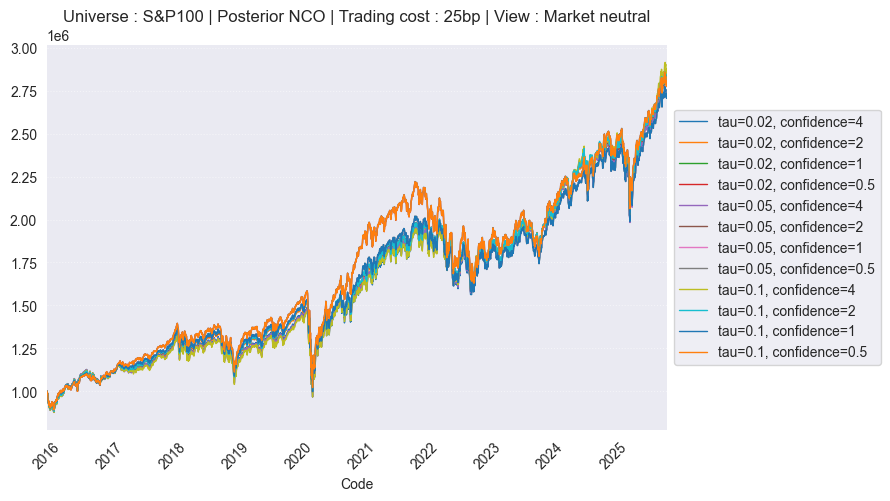

In [53]:
fig, ax = plt.subplots(figsize = (8, 5))

market_weight_res.plot(ax = ax, lw = 1)


for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5)

plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))

plt.xticks(rotation = 45)
plt.title('Universe : S&P100 | Posterior NCO | Trading cost : 25bp | View : Market neutral')
plt.show()

In [54]:
post_nco_weight_market_cap = rolling_posterior_nco(
    weekly_ret,
    market_weight,
    lookback_days=252,
    linkage_method='ward',
    within='ivp',
    delta=3.0,
    tau=0.1,
    confidence=4,
    denoise=True,
    detone=True,
    fillna_zero=True
)

In [55]:
from scipy.stats import skew, kurtosis, norm

def effective_sample_size_ar1(r: pd.Series) -> float:
    """
    Compute effective sample size under AR(1) dependence: N_eff = N * (1 - rho1) / (1 + rho1).
    r: daily excess returns (pd.Series)
    """
    r = pd.Series(r).dropna()
    N = len(r)
    if N < 3:
        return float(N)
    rho1 = r.autocorr(lag=1)
    if np.isnan(rho1):
        rho1 = 0.0
    Neff = N * (1.0 - rho1) / (1.0 + rho1)
    return float(np.clip(Neff, 1.0, N))

def sharpe_daily(r: pd.Series) -> float:
    """
    Sample Sharpe (daily): mean(r) / std(r). Uses population ddof=0 for compatibility with PSR/DSR formulas.
    """
    r = pd.Series(r).dropna()
    s = r.std(ddof=0)
    return float(r.mean() / s) if s > 0 else 0.0

def psr(r: pd.Series, S_star: float = 0.0) -> float:
    """
    Probabilistic Sharpe Ratio (PSR) — Bailey & Lopez de Prado (2012).
    r: daily excess returns (pd.Series)
    S_star: benchmark Sharpe to exceed (e.g., 0)
    """
    r = pd.Series(r).dropna()
    if len(r) < 3:
        return np.nan
    S_hat = sharpe_daily(r)
    N_eff = effective_sample_size_ar1(r)
    g3 = skew(r, bias=False)               # sample skewness
    g4 = kurtosis(r, fisher=False, bias=False)  # Pearson kurtosis (3 = normal)
    denom = np.sqrt(max(1e-12, 1.0 - g3 * S_hat + (g4 - 1.0) * (S_hat ** 2)))
    z = (S_hat - S_star) * np.sqrt(N_eff - 1.0) / denom
    return float(norm.cdf(z))

def dsr(r: pd.Series, n_strategies: int = 1) -> float:
    """
    Deflated Sharpe Ratio (DSR) — Bailey & Lopez de Prado (2014/2015).
    Approximates selection bias by replacing S* with S*_d = sigma_SR * Phi^{-1}(1 - 1/n_strategies).
    r: daily excess returns (pd.Series)
    n_strategies: number of 'trials' (model/param variants) tested
    """
    r = pd.Series(r).dropna()
    if len(r) < 3 or n_strategies < 1:
        return np.nan
    S_hat = sharpe_daily(r)
    N_eff = effective_sample_size_ar1(r)
    g3 = skew(r, bias=False)
    g4 = kurtosis(r, fisher=False, bias=False)
    # Standard error of Sharpe under non-normality (Bailey 2012, Eq. for PSR denominator)
    sigma_SR = np.sqrt(max(1e-12, (1.0 - g3 * S_hat + (g4 - 1.0) * S_hat ** 2) / (N_eff - 1.0)))
    # Deflated threshold
    zq = norm.ppf(1.0 - 1.0 / max(2.0, float(n_strategies)))  # guard for n_strategies>=2; else very conservative
    S_star_deflated = sigma_SR * zq
    denom = np.sqrt(max(1e-12, 1.0 - g3 * S_hat + (g4 - 1.0) * S_hat ** 2))
    z = (S_hat - S_star_deflated) * np.sqrt(N_eff - 1.0) / denom
    return float(norm.cdf(z))

def equity_curve(r: pd.Series, start_value: float = 1.0) -> pd.Series:
    """
    Equity curve from daily returns r (simple returns).
    """
    r = pd.Series(r).fillna(0.0)
    return pd.Series(start_value, index=[r.index[0]]).append((1.0 + r).cumprod() * start_value).iloc[1:].rename("equity")

def drawdown_series(equity: pd.Series) -> pd.Series:
    """
    Drawdown series DD_t = 1 - V_t / max_{s<=t} V_s
    """
    equity = pd.Series(equity).astype(float)
    roll_max = equity.cummax()
    dd = 1.0 - (equity / roll_max.replace(0.0, np.nan))
    return dd.fillna(0.0).rename("drawdown")

def max_drawdown(equity: pd.Series) -> float:
    """
    Maximum drawdown scalar.
    """
    dd = drawdown_series(equity)
    return float(dd.max())

def hhi_timeseries(weights: pd.DataFrame, use_abs: bool = True, renormalize: bool = True) -> pd.Series:
    """
    HHI_t = sum_i w_{i,t}^2
    weights: DataFrame (dates x assets)
    use_abs: 절대값 기준 정규화 사용할지 여부(롱온리라면 False 가능)
    renormalize: 각 시점에서 합이 1이 되도록 재정규화 (결측·부호 고려)
    """
    W = weights.copy().fillna(0.0)
    if use_abs:
        W = W.abs()
    if renormalize:
        s = W.sum(axis=1).replace(0.0, np.nan)
        W = W.div(s, axis=0).fillna(0.0)
    hhi = (W ** 2).sum(axis=1).rename("HHI")
    return hhi

def neff_timeseries(weights: pd.DataFrame, use_abs: bool = True, renormalize: bool = True) -> pd.Series:
    """
    N_eff,t = 1 / sum_i w_{i,t}^2
    """
    hhi = hhi_timeseries(weights, use_abs=use_abs, renormalize=renormalize)
    neff = (1.0 / hhi.replace(0.0, np.nan)).fillna(np.nan).rename("N_eff")
    return neff

# =========================
# Convenience wrapper
# =========================

def compute_metrics_daily(
    r_daily: pd.Series,
    weights_daily: pd.DataFrame,
    n_strategies: int = 1,
    start_value: float = 1.0,
) -> dict:
    """
    Compute PSR, DSR, MDD (scalar) and HHI/N_eff (time series) from daily data.

    Parameters
    ----------
    r_daily : pd.Series
        Daily excess returns of the portfolio (simple returns).
    weights_daily : pd.DataFrame
        Daily portfolio weights (dates x assets).
    n_strategies : int
        Number of strategies/variants tried (for DSR).
    start_value : float
        Initial equity value for drawdown computations.

    Returns
    -------
    {
      "PSR": float,
      "DSR": float,
      "MDD": float,
      "equity": pd.Series,
      "drawdown": pd.Series,
      "HHI": pd.Series,
      "N_eff": pd.Series,
    }
    """
    r_daily = pd.Series(r_daily).dropna()
    eq = equity_curve(r_daily, start_value=start_value)
    dd = drawdown_series(eq)
    out = {
        "PSR": psr(r_daily, S_star=0.0),
        "DSR": dsr(r_daily, n_strategies=n_strategies),
        "MDD": max_drawdown(eq),
        "equity": eq,
        "drawdown": dd,
        "HHI": hhi_timeseries(weights_daily, use_abs=True, renormalize=True),
        "N_eff": neff_timeseries(weights_daily, use_abs=True, renormalize=True),
    }
    return out

<Axes: xlabel='Code'>

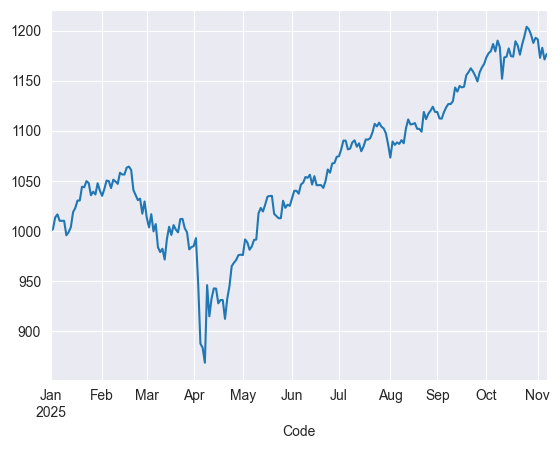

In [56]:
(ledger.loc['2025', 'portfolio_value'] / ledger.loc['2025-01-01', 'portfolio_value'] * 1000).plot()

In [57]:
ledger, positions, trades = build_ledger_from_daily_prices_and_weights_monthly(
    price.loc['2015-12-31':],
    post_nco_weight_market_cap.loc['2015-12-31':],
    initial_capital=1_000_000,
    tc_bps=25,
    weight_lag_days=0
)
years = (ledger.index[-1] - ledger.index[0]).days / 365.25
annual_turnover = ledger['turnover_pct'].sum() / years
print(ledger['portfolio_value'].iloc[-1] / ledger['portfolio_value'].iloc[0] - 1)
print(f"연평균수익률 : {ledger['portfolio_value'].pct_change().mean() * 262 : .6f}")
print(f"연율화된 표준편차 : {ledger['portfolio_value'].pct_change().std() * np.sqrt(262) : .6f}")
print(
    f"Sharpe Ratio : {ledger['portfolio_value'].pct_change().mean() / ledger['portfolio_value'].pct_change().std() * np.sqrt(252) : .6f}")
print(f"PSR(SR* = 0) : {psr(ledger['portfolio_value'].pct_change()) : .6f}")
print(f"DSR(n = 10) : {dsr(ledger['portfolio_value'].pct_change(), n_strategies=10) : .6f}")
print(f"MDD : {max_drawdown(ledger['portfolio_value']) : .6f}")
print(f"Annual Turnover : {annual_turnover:.6f}")
print(
    f"Average HHI : {hhi_timeseries(weights=post_nco_weight_market_cap.loc['2017-12-29':], use_abs=True, renormalize=True).mean() : .6f}")
print(
    f"Average N efficient : {neff_timeseries(weights=post_nco_weight_market_cap.loc['2017-12-29':], use_abs=True, renormalize=True).mean() : .6f}")

1.8468925350694234
연평균수익률 :  0.123550
연율화된 표준편차 :  0.183707
Sharpe Ratio :  0.659578
PSR(SR* = 0) :  0.980678
DSR(n = 10) :  0.784188
MDD :  0.340006
Annual Turnover : 2.754791
Average HHI :  0.147983
Average N efficient :  6.838598


In [58]:
post_nco_weight_market_cap.loc['2025-10-31'].sort_values(ascending = False)

XLK-US     0.344159
XLF-US     0.142122
SMH-US     0.103418
XLV-US     0.100660
GDX-US     0.069840
XLE-US     0.065813
XLY-US     0.052706
SOXX-US    0.036748
XLC-US     0.032643
XLP-US     0.021910
XLI-US     0.014076
XLRE-US    0.012676
CIBR-US    0.003230
PAVE-US    0.000000
IBB-US     0.000000
XBI-US     0.000000
REZ-US     0.000000
ARKF-US    0.000000
FINX-US    0.000000
IDRV-US    0.000000
XME-US     0.000000
ITA-US     0.000000
WCLD-US    0.000000
DRIV-US    0.000000
TAN-US     0.000000
ICLN-US    0.000000
BUG-US     0.000000
CLOU-US    0.000000
AIQ-US     0.000000
BOTZ-US    0.000000
XLU-US     0.000000
XLB-US     0.000000
QTUM-US    0.000000
Name: 2025-10-31 00:00:00, dtype: float64